In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
# Driver
spark = SparkSession \
    .builder \
    .master('local') \
    .appName('SparkProj') \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.4") \
    .config("spark.shuffle.spill", "true") \
    .config("spark.shuffle.spill.compress", "true") \
    .getOrCreate()

# define dataset files path
business_path = 'dataset/yelp_academic_dataset_business.json'
checkin_path = 'dataset/yelp_academic_dataset_checkin.json'
review_path = 'dataset/yelp_academic_dataset_review.json'
tip_path = 'dataset/yelp_academic_dataset_tip.json'
user_path = 'dataset/yelp_academic_dataset_user.json'

df = spark.read.json(review_path).limit(10000)
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [2]:
df.na.drop(how='all', subset=['text']).show()
# exploded_c_df = c_df.withColumn("date", explode(split(col("date"), ", ")))
# exploded_c_df.show()
df.select(col('text')).show()
df.select("text").show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [31]:
import re
import nltk
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import MWETokenizer
from nltk.corpus import wordnet
wnl = WordNetLemmatizer()

def get_word_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [32]:
from pyspark.ml.feature import Tokenizer,RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import re
import string

def remove_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    return nopunct
 
punct_remover = udf(lambda x: remove_punct(x))
#去标点符号分词
df_clean = df.select('text').withColumn('remove_punctuation',punct_remover('text')).drop('text') #可以添加除了text的其他字段
tokenizer = RegexTokenizer(inputCol="remove_punctuation", outputCol="tokenized",pattern='\\s+')
tokenized_df = tokenizer.transform(df_clean)
#去停用词
remover = StopWordsRemover(inputCol="tokenized", outputCol="remove_stop_words")
remove_stop_words_df = remover.transform(tokenized_df.drop('remove_punctuation'))
remove_stop_words_df.drop('tokenized').show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|remove_stop_words                                                                                                                                                                                                                                                                                                                                                                

In [33]:
word_dict = {}
remove_stop_words_list_modified = []
val = remove_stop_words_df.select('remove_stop_words').collect()
remove_stop_words_list = [ ele.__getattr__('remove_stop_words') for ele in val]
for t in remove_stop_words_list:
    refiltered =nltk.pos_tag(t)
    lemmas_sent = []
    for wordtag in refiltered:
        wordnet_pos = get_word_pos(wordtag[1]) or wordnet.NOUN
        word = wnl.lemmatize(wordtag[0], pos=wordnet_pos)
        lemmas_sent.append(word) # 词形还原
        word_dict[word] = word_dict.get(word,0)+1
    remove_stop_words_list_modified.append(lemmas_sent)


In [34]:
wordfreq = pd.DataFrame({'word':word_dict.keys(),'freq':word_dict.values()})
wordfreq = wordfreq.sort_values(by='freq', ascending=False)

wordfreq.to_excel("wordfreq.xlsx",index=False)

keywords: Index(['good', 'place', 'get', 'food', 'go', 'great', 'time', 'service',
       'like', 'order', 'come', 'one', 'make', 'back', 'well', 'really', 'try',
       'love', 'take', 'also', 'say', 've', 'u', 'nice', 'restaurant', 'best',
       'look', 'even', 'wait', 'price', 'staff', 'want', 'give', 'friendly',
       'm', 'always', 'delicious', 'little', 'chicken', 'menu', 'know', 'didn',
       'first', 'drink', 'definitely', 'find', 'day', 'eat', 'think', 'table'],
      dtype='object', name='word')
            good  place  get  food   go  great  time  service  like  order  \
good           0    167  135   459   48     62    84      294    37     40   
place        167      0  124    95  291    366    31       33   155     81   
get          135    124    0   158  108     56   107       42    28     83   
food         459     95  158     0   70    438    41      210    52    124   
go            48    291  108    70    0     36   156       37    42     69   
great         62  

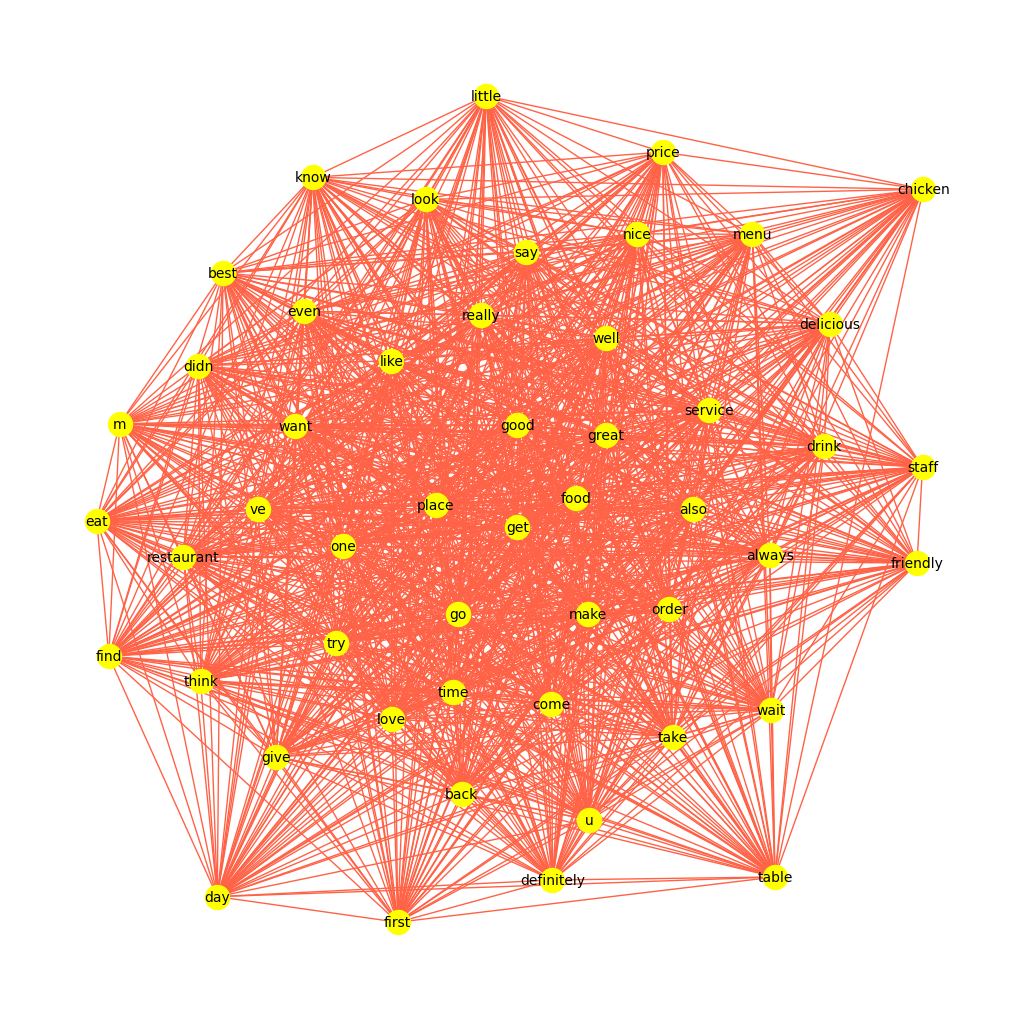

In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

word_series = pd.Series(data=wordfreq['freq'].values, index=wordfreq['word'])

keywords = word_series[:50].index#词频数前50的作为共现矩阵的关键词
print('keywords:',keywords)
matrix = np.zeros((len(keywords)+1)*(len(keywords)+1)).reshape(len(keywords)+1, len(keywords)+1).astype(str)
matrix[0][0] = np.NaN
matrix[1:, 0] = matrix[0, 1:] = keywords

for i, w1 in enumerate(word_series[:50].index):
    for j, w2 in enumerate(word_series[:50].index):
        if w1 == w2:  # 如果关键词与其自身相同，跳过此次循环
            continue
        count = 0
        for cont in remove_stop_words_list_modified:
            pairs = list(zip(cont, cont[1:]))
            if (w1, w2) in pairs or (w2, w1) in pairs:
                count += 1
        matrix[i+1][j+1] = count
#在创建共现矩阵时，对于每对关键词，检查它们在文本中的出现是否相邻
# （abs(cont.index(w1)-cont.index(w2)) == 0 or abs(cont.index(w1)-cont.index(w2)) == 1）。
# 这种方法确保了只有在相邻或相同位置出现的关键词才会被考虑。这可能会导致某些关键词之间没有直接的连接，从而在最终的网络中被排除。
kwdata = pd.DataFrame(data=matrix)
kwdata.to_csv('关键词共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')
kwdata= pd.read_csv('关键词共现矩阵.csv')
kwdata .index = kwdata .iloc[:, 0].tolist()

kwdata_ =  kwdata.iloc[:, 1:]
print(kwdata_.astype(int))
kwdata_.astype(int)


plt.figure(figsize=(10, 10))  # 增大图形的大小
graph1 = nx.from_pandas_adjacency(kwdata_)
# 使用 spring_layout
pos = nx.spring_layout(graph1, k=0.5)  # k值决定节点间的距离，值越大距离越近
nx.draw(graph1, pos, with_labels=True, node_color='yellow', font_size=10, node_size=300, edge_color='tomato')
plt.savefig('语料共现网络图.jpg')

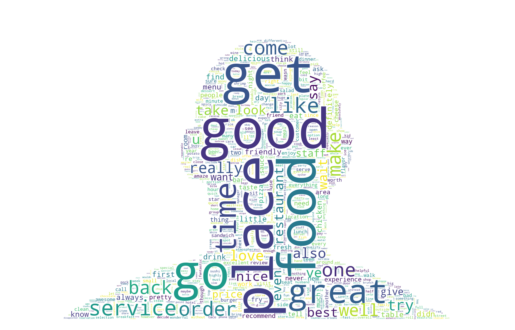

In [43]:
import multidict as multidict
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def makeImage(text):
    alice_mask = np.array(Image.open("1.png"))

    wc = WordCloud(background_color="white", max_words=1000, mask=alice_mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


makeImage(word_dict)